In [1]:
!pip install -q transformers opencc

     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 766 kB 59.1 MB/s 
     |████████████████████████████████| 6.6 MB 43.2 MB/s 
     |████████████████████████████████| 596 kB 70.1 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 


In [ ]:
# Not needed in this notebook, but just keep the url for reference
# !wget https://ai.tencent.com/ailab/nlp/en/data/tencent-ailab-embedding-zh-d100-v0.2.0-s.tar.gz

--2022-04-23 12:14:11--  https://ai.tencent.com/ailab/nlp/en/data/tencent-ailab-embedding-zh-d100-v0.2.0-s.tar.gz
Resolving ai.tencent.com (ai.tencent.com)... 116.128.164.87
Connecting to ai.tencent.com (ai.tencent.com)|116.128.164.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799232206 (762M) [application/octet-stream]
Saving to: ‘tencent-ailab-embedding-zh-d100-v0.2.0-s.tar.gz’

tencent-ailab-embed 100%[===================>] 762.21M  8.16MB/s    in 1m 49s  

2022-04-23 12:16:01 (7.01 MB/s) - ‘tencent-ailab-embedding-zh-d100-v0.2.0-s.tar.gz’ saved [799232206/799232206]



In [2]:
import numpy as np
from tqdm.auto import tqdm
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertPreTrainedModel
from opencc import OpenCC
t2s = OpenCC('t2s')
N = 500000

## Preprocessing Embeddings

In [3]:
import json
with open("drive/MyDrive/LangOn/morphert/train_test_split_500k.json", "r") as fin:
  idxs = json.load(fin)
  train_idxs = idxs["train"]
  test_idxs = idxs["test"]

In [4]:
with open("drive/MyDrive/LangOn/morphert/tencent_small_500k.pkl", "rb") as fin:
  (vocabs, embs) = pickle.load(fin)

In [5]:
vocabs[6558], embs[6558]

('说什么', array([ 0.11927852, -0.12477621, -0.00780427, -0.20220207, -0.12248462,
         0.09576039, -0.1549168 , -0.05301735,  0.02143643,  0.1200113 ,
        -0.06519454,  0.14092922,  0.12549583, -0.08167701, -0.17365649,
        -0.08256081,  0.03598054, -0.01726389, -0.00291723,  0.13104874,
        -0.03672575, -0.16984083, -0.11822981, -0.02188655, -0.0179612 ,
         0.09294079,  0.13191718,  0.20639436, -0.03133885,  0.02851779,
         0.02657138,  0.07973024, -0.01196658,  0.00117048,  0.03134397,
         0.16240258,  0.0738625 ,  0.0008838 , -0.00090208,  0.02884579,
        -0.05542522, -0.00448262, -0.07189087, -0.11853733, -0.07589301,
         0.15974716,  0.05274018,  0.1863489 ,  0.06927165,  0.01917007,
        -0.11809305, -0.11048221,  0.05883755, -0.01623858, -0.11332046,
        -0.06050496,  0.01738346,  0.15817337, -0.08151137, -0.04895926,
        -0.0893449 , -0.03123172,  0.14792064,  0.0461861 ,  0.0399505 ,
        -0.09982616,  0.11309339, -0.1126666

## Prepare Dataset

In [6]:

class MorphertDataset(Dataset):
  def __init__(self, idxs, vocabs, embs):
    assert max(idxs) < len(vocabs)
    assert max(idxs) < embs.shape[0]
    self.vocabs = vocabs
    self.embs = embs
    self.idxs = idxs

  def __len__(self):
    return len(self.idxs)

  def __getitem__(self, idx):
    idx = self.idxs[idx]
    return {
        "word": self.vocabs[idx],
        "vec": self.embs[idx, :],
    }

  def get_word(self, idx):
    return self.vocabs[self.idxs[idx]]

In [7]:
train_dataset = MorphertDataset(train_idxs, vocabs, embs)
test_dataset = MorphertDataset(test_idxs, vocabs, embs)

In [8]:
len(train_dataset), len(test_dataset)

(490000, 10000)

In [86]:
### Train statistics
from collections import Counter
from itertools import chain
n_train_char_tokens = sum(len(vocabs[x]) for x in train_idxs)
n_train_char_types = len(set(chain.from_iterable(vocabs[x] for x in train_idxs)))
n_train_wlen = Counter(len(vocabs[x]) for x in train_idxs)

print("train char tokens: ", n_train_char_tokens)
print("train char types: ", n_train_char_types)
print("1-char word: ", n_train_wlen[1])
print("2-char word: ", n_train_wlen[2])
print("3-char word: ", n_train_wlen[3])
print("4-char word: ", n_train_wlen[4])
print(">4-char word: ", sum(x for wlen, x in n_train_wlen.items() if wlen>4))

train char tokens:  1809674
train char types:  8749
1-char word:  7792
2-char word:  119062
3-char word:  103099
4-char word:  166330
>4-char word:  93717


In [87]:
### Train statistics
from collections import Counter
from itertools import chain
n_test_char_tokens = sum(len(vocabs[x]) for x in test_idxs)
n_test_char_types = len(set(chain.from_iterable(vocabs[x] for x in test_idxs)))
n_test_wlen = Counter(len(vocabs[x]) for x in test_idxs)

print("train char tokens: ", n_test_char_tokens)
print("train char types: ", n_test_char_types)
print("1-char word: ", n_test_wlen[1])
print("2-char word: ", n_test_wlen[2])
print("3-char word: ", n_test_wlen[3])
print("4-char word: ", n_test_wlen[4])
print(">4-char word: ", sum(x for wlen, x in n_test_wlen.items() if wlen>4))

train char tokens:  36538
train char types:  2944
1-char word:  162
2-char word:  2522
3-char word:  2123
4-char word:  3375
>4-char word:  1818


In [89]:
[vocabs[x] for x in test_idxs if len(vocabs[x])==4][:10]

['乘坐高铁',
 '高级经济',
 '不同角度',
 '全球研发',
 '品牌公司',
 '黄金水道',
 '园林建筑',
 '打开大门',
 '焦躁不安',
 '本人签字']

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [10]:
class DataCollator:
  def __init__(self, tokenizer, device=None):
    if not device:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
      self.device = device
    self.tokenizer = tokenizer

  def __call__(self, Xs):
    words = [x["word"] for x in Xs]
    vec = np.vstack([x["vec"] for x in Xs])
    vec = torch.tensor(vec, dtype=torch.float32).to(self.device)
    input_batch = self.tokenizer(words, return_tensors="pt", padding="longest")
    input_batch = input_batch.to(self.device)     
    return {
        **input_batch, "labels": vec, "words": words
    }

In [11]:
import torch.nn as nn
from dataclasses import dataclass

@dataclass
class MorphertOutput:
  loss: float
  predictions: np.ndarray

class MorphertModel(BertPreTrainedModel):
  def __init__(self, config, *args, **kwargs):
    super().__init__(config, **kwargs)
    emb_dim = kwargs.get("emb_dim", 100)
    hdim = self.config.hidden_size
    self.bert = BertModel(config)
    self.proj = nn.Linear(hdim, emb_dim)
  
  def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs
    ):
        
    outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
    cls_vec = outputs.last_hidden_state[:, 0]
    pred_vec = self.proj(cls_vec)    

    if labels is not None:
      loss_fct = nn.MSELoss()
      loss = loss_fct(pred_vec, labels)
    else:
      loss = float("NaN")

    return MorphertOutput(loss, pred_vec)

## Evaluation

In [12]:
base_dir = "/content/drive/My Drive/LangOn/morphert"
model = MorphertModel.from_pretrained(base_dir + "/morphert_500k")
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
collator_fn = DataCollator(tokenizer)
model = model.to("cuda")

In [13]:
from scipy.spatial.distance import cdist
rng = np.random.RandomState(123)

In [19]:
def compute_metric(ref_words, pred_vecs, ref_emb, ds):
  dist_mat = cdist(pred_vecs, ref_emb)  
  pred_idxs = np.argmin(dist_mat, axis=1)
  pred_words = [ds.get_word(x) for x in pred_idxs]
  # print(*[(a,b) for a, b in zip(pred_words, ref_words)], sep="\n")
  return sum((a==b for a, b in zip(pred_words, ref_words)))

def compute_metric_topk(ref_words, pred_vecs, ref_emb, ds, k=5, return_vector=False):
  dist_mat = cdist(pred_vecs, ref_emb)
  pred_idxs = np.argsort(dist_mat, axis=1)[:, :k]
  pred_words = [[ds.get_word(x) for x in row] for row in pred_idxs]
  if return_vector:
    ret = []
    for preds, ref in zip(pred_words, ref_words):
      try:
        pos = preds.index(ref)
        ret.append(pos)
      except ValueError:
        ret.append(-1)
    return ret
  else:
    return sum(((ref in preds) for preds, ref in zip(pred_words, ref_words)))

### Test eval

In [21]:
test_dataset = MorphertDataset(test_idxs, vocabs, embs)
test_emb = np.vstack([test_dataset[i]["vec"] for i in range(len(test_dataset))])
test_loader = DataLoader(test_dataset, collate_fn=collator_fn, batch_size=16, shuffle=False)

In [45]:
model.eval()
n_correct = 0
correct_idxs = []
ref_word_list = []
n_items = 0

with torch.no_grad():
  for batch_x in tqdm(test_loader):        
    out = model(**batch_x)
    ref_words = batch_x["words"]
    pred_vecs = out.predictions.cpu().numpy()
    n_correct_x = compute_metric(ref_words, pred_vecs, test_emb, test_dataset)
    correct_vec = compute_metric_topk(ref_words, pred_vecs, test_emb, test_dataset, k=20, return_vector=True)    
    n_correct += n_correct_x
    correct_idxs.extend(correct_vec)
    ref_word_list.extend(ref_words)
    n_items += len(ref_words)    
print("Test Acc: {:.4f}".format(n_correct / n_items))

  0%|          | 0/625 [00:00<?, ?it/s]

Test Acc: 0.6693


In [52]:
# statistics
from collections import Counter
Ks = (1,5,10,20)
corrects_map = {}
wlen_count = Counter(len(x) for x in ref_word_list)
for ref, idx in zip(ref_word_list, correct_idxs):
  if idx < 0: continue # not in top-K
  wlen = len(ref)
  for k in Ks:
    kmap = corrects_map.setdefault(k, Counter())
    kmap[wlen] += int(idx <= k-1)


In [75]:
correct_data = []
for n in (1,2,3,4,5):
  if n < 5:
    N = wlen_count[n]
    correct_data.append([N, 
                     corrects_map[1][n], corrects_map[5][n],
                     corrects_map[10][n], corrects_map[20][n]])
  else:
    N = sum(x for wlen, x in wlen_count.items() if wlen >= 5)
    sum_correct = lambda k: sum(x 
                                for wlen, x in corrects_map[k].items() 
                                if wlen>=5)
    correct_data.append([N,
                     sum_correct(1), sum_correct(5),
                     sum_correct(10), sum_correct(20)])
correct_data = np.array(correct_data)
correct_data = np.vstack([correct_data, correct_data.sum(axis=0)])

In [83]:
import pandas as pd
acc_data = correct_data.copy().astype(np.float64)
for i in range(1, 5):
  acc_data[:, i] = correct_data[:, i]/correct_data[:, 0]
acc_frame = pd.DataFrame(
              acc_data, index="1,2,3,4,>4,all".split(","),
              columns="N,Top1,Top5,Top10,Top20".split(","))
acc_frame["N"] = acc_frame.N.astype(np.int32)
acc_frame

,N,Top1,Top5,Top10,Top20
1,162,0.734568,0.851852,0.864198,0.888889
2,2522,0.632435,0.776368,0.814036,0.849722
3,2123,0.662741,0.792746,0.837023,0.869524
4,3375,0.750815,0.866963,0.897481,0.921481
>4,1818,0.570957,0.723322,0.768977,0.812431
all,10000,0.669300,0.802000,0.839700,0.872000


### Training set predictions

In [15]:
sub_idxs = np.arange(len(train_idxs))
rng.shuffle(sub_idxs)
sub_train = MorphertDataset(sub_idxs[:10000], vocabs, embs)
sub_train_emb = np.vstack([sub_train[i]["vec"] for i in range(len(sub_train))])

In [16]:
model.eval()
sub_train_loader = DataLoader(sub_train, collate_fn=collator_fn, batch_size=16, shuffle=True)
n_correct = 0
n_correct_topk = 0
n_items = 0
with torch.no_grad():
  for batch_x in tqdm(sub_train_loader):        
    out = model(**batch_x)
    ref_words = batch_x["words"]
    pred_vecs = out.predictions.cpu().numpy()
    n_correct_x = compute_metric(ref_words, pred_vecs, sub_train_emb, sub_train)
    n_correct_k = compute_metric_topk(ref_words, pred_vecs, sub_train_emb, sub_train, k=1)
    n_correct += n_correct_x
    n_correct_topk += n_correct_k
    n_items += len(ref_words)
print("Train(subsample) Acc: {:.4f}".format(n_correct / n_items))
print("Train(subsample) Topk: {:.4f}".format(n_correct_topk / n_items))

  0%|          | 0/625 [00:00<?, ?it/s]

Train(subsample) Acc: 0.7062
Train(subsample) Topk: 0.7062


## Prediction Exploration

In [ ]:
full_ds = MorphertDataset(np.arange(N), vocabs, embs)
full_emb = np.vstack([full_ds[i]["vec"] for i in range(N)])

In [ ]:
def predict_neighbors(texts):
  model.eval()
  in_batch = tokenizer(texts, padding=True, return_tensors="pt")
  in_batch = in_batch.to("cuda")
  with torch.no_grad():    
    out = model(**in_batch)  
    pred_vecs = out.predictions.cpu().numpy()
    dist_mat = cdist(pred_vecs, full_emb)  
    pred_idxs = np.argsort(dist_mat, axis=1)

    topk = 5
    for i, word in enumerate(texts):
      pred_x = pred_idxs[i, :]
      pred_words = [full_ds.get_word(x) for x in pred_x[:topk]]
      marker = "*" if word not in full_ds.vocabs else " "
      print(marker, word+":", " ".join(pred_words))

In [ ]:
predict_neighbors(["政府", "電影", "鍵盤", "歡天喜地", "欢天喜地", "無三不成禮", "傅潘達"])

  政府: 政府 政府部门 是政府 财政 部门
  電影: 電影 劇情 電視劇 紀錄片 喜劇
  鍵盤: 鍵盤 電腦 開關 機器 鍵
* 歡天喜地: 快樂 開心 歡樂 慶祝 聯
  欢天喜地: 欢天喜地 欢欢喜喜 喜气洋洋 高高兴兴 笑逐颜开
* 無三不成禮: 絕對 罷 禮 應 絕
* 傅潘達: 傑克 兩人 當時 他們 演員


In [ ]:
word = "名古屋大學"
predict_neighbors([word[:i] for i in range(1, len(word)+1)])
predict_neighbors([word[-i:] for i in range(len(word)-1, 0, -1)])

  名: 名 个 名子 名字 位
* 名古: 奇珍 稀世 古老 三绝 八景
  名古屋: 大阪 福冈 名古屋 东京 日本东京
* 名古屋大: 日本东京 福冈 大阪 名古屋 新宿
* 名古屋大學: 國立 學院 教師 東京 大學
* 古屋大學: 國立 學院 教師 學生會 大學
* 屋大學: 學院 國立 倫敦 實驗室 英國
  大學: 大學 學校 學院 中學 小學
  學: 學習 學 讀 習 大學


In [ ]:
model.bert.embeddings.position_embeddings.weight.detach().cpu().numpy()

array([[-0.0001821 ,  0.00868429, -0.00764077, ..., -0.03098033,
        -0.00660864, -0.00147766],
       [-0.0099496 ,  0.00413624, -0.00812588, ..., -0.06616209,
        -0.01035381,  0.00638527],
       [ 0.00853468, -0.00175859, -0.01403376, ..., -0.04447036,
         0.0183649 ,  0.01120223],
       ...,
       [-0.01567218,  0.02754869,  0.01669503, ..., -0.03805819,
         0.00735981, -0.00570755],
       [-0.00579407,  0.03675492, -0.01893283, ..., -0.01591158,
        -0.02278237, -0.04126066],
       [ 0.00444494,  0.07190142, -0.04078597, ...,  0.02001504,
        -0.00944421, -0.02104169]], dtype=float32)

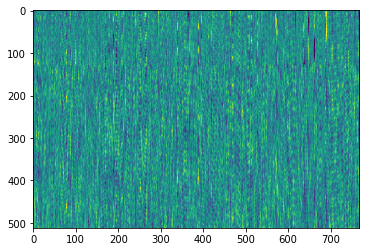

In [ ]:
plt.imshow(model.bert.embeddings.position_embeddings.weight.detach().cpu().numpy(), vmin=-0.05, vmax=0.05)

In [ ]:
model.bert.embeddings(torch.tensor([[1000,1002]]).to("cuda"))

tensor([[[-0.6767,  0.6250,  0.9545,  ...,  0.4151,  0.1406,  0.3705],
         [ 0.4629,  0.5397,  0.1355,  ..., -0.2454,  0.2921, -0.4961]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
model.bert.embeddings(torch.tensor([[1002,1000]]).to("cuda"))

tensor([[[ 0.4465,  0.4691,  0.1123,  ...,  0.0831,  0.2598, -0.4699],
         [-0.9721,  0.7282,  1.2025,  ...,  0.1829,  0.1353,  0.5788]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
p1 = model.bert.embeddings.position_embeddings(torch.tensor([[1]]).to("cuda"))

In [ ]:
w1000 = model.bert.embeddings(torch.tensor([[1000]]).to("cuda"))

In [ ]:
wemb = model.bert.embeddings.word_embeddings.weight

In [ ]:
wemb.mean(axis=0).quantile(torch.tensor([0.1, 0.5, 0.9]).cuda())

tensor([-0.0173, -0.0003,  0.0120], device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
norm_wemb = wemb / wemb.norm(dim=1).unsqueeze(1)

In [ ]:
tgt_idx = tokenizer.convert_tokens_to_ids(["房"])
sorted_idxs = torch.argsort(-torch.matmul(norm_wemb, norm_wemb[tgt_idx[0]]))
tokenizer.convert_ids_to_tokens(sorted_idxs[:20])

['房',
 '屋',
 '楼',
 '樓',
 '室',
 '墅',
 '店',
 '宅',
 'house',
 '住',
 'room',
 '院',
 '床',
 '##house',
 '车',
 '厅',
 '城',
 '居',
 '棚',
 '柜']